In [1]:
"""Sandbox module."""

import numpy as np
from data_generation import (
    gen_discretized_distributions,
    gen_grids_and_parameters,
)

from misc import (
    riemann_sum_arrays,
    trunc_norm_pdf,
    cdf_from_density,
    quantile_from_density,
)

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("always")
from scipy.integrate import quad
from scipy.interpolate import interp1d, UnivariateSpline, CubicSpline

In [3]:
import matplotlib.pyplot as plt

In [4]:
# Set up data
n = 200
gridnum = 1000
truncation_point = 3

grid_pdfs, grid_qfs, mus, sigmas = gen_grids_and_parameters(
    n, gridnum, truncation_point, delta=0,
)

In [5]:
def smooth_boundary_1d(arr, dsup):
    boundary_indices = [0, 1, -2, -1]  # Example: first and last two points
    boundary_points = dsup[boundary_indices]
    boundary_values = arr[boundary_indices]
    
    spline = UnivariateSpline(boundary_points, boundary_values, s=0.001)  # Adjust s as needed
    arr[boundary_indices] = spline(boundary_points)
    return arr

In [6]:
def midpoint_riemann_sum_arrays(support_grid, array, axis=-1, cumsum=False):
    """Computes the Riemann sum using the Midpoint rule for the given array, along
    the axis that contains the grid of values."""
    
    # Calculate the step size between consecutive grid points
    step_sizes = np.diff(support_grid)
    
    # Calculate midpoints
    midpoints = (support_grid[..., 1:] + support_grid[..., :-1]) / 2
    
    # Sample the function at the midpoints
    midpoint_values = np.array(step_sizes.shape)
    for i in range(len(midpoint_values)):
        midpoint_values[i] = np.interp(midpoints[i], support_grid, array[i])
    
    # Compute the cumulative sum along the specified axis (i.e.,
    # the integral up to each grid point)
    if cumsum:
        result = np.cumsum(midpoint_values * step_sizes, axis=axis)
    # Or just the integral
    else:
        result = np.sum(midpoint_values * step_sizes, axis=axis)

    return result


In [7]:
def dens_from_qd(qds_discretized, qdsup=None, dsup=None):
    """Compute density from a quantile density function.

    'Inspired' from qd2dens in fdadensity package in R.

    """
    # Validate input
    eps = 1e-3
    boundaries = [np.min(qdsup), np.max(qdsup)]
    if not np.allclose(boundaries, [0, 1], atol=eps):
        msg = f"Please check the support of the QF domain's boundaries: {boundaries}"
        raise ValueError(msg)

    integral_qd = riemann_sum_arrays(qdsup, array=qds_discretized, axis=-1, cumsum=True)
    if not np.isclose(integral_qd[-1], np.ptp(dsup), atol=eps):
        msg = (
            "Quantile Density does not integrate to the range of the densities with "
            f"tolerance {eps}."
            f"\n Integral is: {integral_qd[...,-1]}"
            f"\n Range is: {np.ptp(dsup)}"
        )
        raise ValueError(msg)

    # Calculate new support grid
    dsup_temp = dsup[0] + integral_qd

    # Calculate density
    dens_temp = 1 / qds_discretized
    idx_unique = np.unique(dsup_temp, return_index=True, axis=-1)[1]
    dsup_temp = dsup_temp[..., idx_unique] 
    dens_temp = dens_temp[..., idx_unique]
    dens = np.interp(dsup, dsup_temp, dens_temp)

    # Normalize the density
    dens /= riemann_sum_arrays(dsup, dens, axis=-1, cumsum=False)[..., np.newaxis]

    return dens

In [55]:
def qd_from_dens(dens, dsup=None, qdsup=None):
    """Compute quantile densities directly from densities.

    'Inspired' from dens2qd in fdadensity package in R.

    """
    # Validate input
    eps = 1e-3
    boundaries = [np.min(qdsup), np.max(qdsup)]
    if not np.allclose(boundaries, [0, 1], atol=eps):
        msg = f"Please check the support of the QF domain's boundaries: {boundaries}"
        raise ValueError(msg)

    integral_dens = riemann_sum_arrays(dsup, array=dens, axis=-1, cumsum=True)
    deviations_from_1 = abs(integral_dens[...,-1] - 1)
    if np.any(deviations_from_1 > eps):
        warnings.warn(
            f"Not all provided densities integrate to 1 with tolerance {eps}!"
            f"\n Max case of deviation is: {deviations_from_1.max()}"
            f"\n In position: {deviations_from_1.argmax()} "
            "\n Performing normalization...",
        )
        dens /= integral_dens[...,-1][..., np.newaxis]

    spline = CubicSpline(dsup, dens, bc_type="natural", axis=-1)
    qdsup_temp = riemann_sum_arrays(dsup, array=spline(dsup), axis=-1, cumsum=True)
    # qdsup_temp = integral_dens
    
    qd_temp = 1 / dens
    ind = np.unique(qdsup_temp, return_index=True, axis=-1)[1]
    print(ind.shape)
    qdsup_temp = qdsup_temp[..., ind]
    qd_temp = qd_temp[..., ind]
    print(qdsup_temp[0])

    # qd = CubicSpline(qdsup_temp, qd_temp, bc_type="natural", axis=-1)(qdsup)
    if dens.ndim > 1:
        qd = np.zeros(dens.shape)
        for i in range(len(dens)):
            qd[i] = CubicSpline(qdsup_temp[i], qd_temp[i], bc_type="natural", axis=-1)(qdsup)
    else:
        qd = CubicSpline(qdsup_temp, qd_temp, bc_type="natural", axis=-1)(qdsup)

    integral_qd = riemann_sum_arrays(qdsup, qd, axis=-1, cumsum=False)
    # integral_qd = np.trapz(qd, qdsup) / 2
    qd *= np.ptp(dsup) / integral_qd[..., np.newaxis]

    return qd

In [69]:
a = np.array([
    [1, 0, 0],
    [1, 0, 0],
    [2, 3, 4]
])
np.unique(a, axis=0, return_index=True)

(array([[1, 0, 0],
        [2, 3, 4]]),
 array([0, 2], dtype=int64))

In [56]:
def gen_discretized_distributions(grid_pdfs, grid_qfs, mus, sigmas, truncation_point):
    """Generate discretized pdfs, cdfs, qfs, and qdfs."""
    # Truncated pdfs
    pdfs_discretized = trunc_norm_pdf(
        grid_pdfs[:, np.newaxis],
        mus,
        sigmas,
        -truncation_point,
        truncation_point,
    )

    # Truncated cdfs
    cdfs_discretized = cdf_from_density(
        grid_pdfs,
        pdfs_discretized,
        axis=-1,
    )

    # Truncated qfs
    qfs_discretized = quantile_from_density(
        pdfs_discretized,
        grid_pdfs,
        grid_qfs,
    )

    # Truncated qdfs
    qdfs_discretized = qd_from_dens(
        pdfs_discretized, dsup=grid_pdfs, qdsup=grid_qfs,
    )

    return pdfs_discretized, cdfs_discretized, qfs_discretized, qdfs_discretized


In [57]:
# Generate distributions
pdfs_discretized, cdfs_discretized, qfs_discretized, qdfs_discretized = (
    gen_discretized_distributions(grid_pdfs, grid_qfs, mus, sigmas, truncation_point)
)

c:\Coding\frechet_fda\src\frechet_fda\misc.py:71: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 0.006087386759915159
 In position: 40
 Performing normalization...
  warnings.warn(


(200,)
[2.65092260e-06 1.15916534e-08 3.94226172e-10 2.74669101e-10
 4.07251446e-07 7.24328919e-08 3.29639923e-10 3.19239796e-06
 8.54338819e-10 1.88801666e-05 2.09484555e-11 1.93835509e-06
 5.59032008e-10 8.99115270e-07 1.00917391e-09 4.27594979e-09
 5.86867968e-06 1.56847563e-07 6.28031247e-08 3.11106987e-07
 3.12673251e-05 1.78803831e-09 1.27510651e-11 1.95755306e-08
 1.24993765e-08 2.49084892e-06 3.79164829e-08 1.25770266e-10
 3.04646869e-08 1.99816990e-05 3.06558370e-11 1.41842825e-05
 4.71186242e-08 5.20267594e-06 1.01468717e-10 8.34830298e-08
 3.61054681e-06 6.23146601e-06 6.48275128e-07 5.39832021e-09
 5.83352209e-12 2.79229881e-12 6.09123637e-10 1.81980940e-06
 4.07715084e-08 7.92927240e-09 9.59425399e-07 3.56065805e-07
 3.80831143e-07 9.23506850e-09 1.70607601e-10 8.39015613e-06
 1.16457721e-06 1.10674801e-07 1.60323146e-06 2.06428278e-06
 2.19802927e-06 9.96372798e-09 7.85590848e-10 4.35432484e-07
 2.50344024e-10 2.27466005e-09 8.90004593e-06 2.09983277e-09
 1.00097452e-05 5

ValueError: `x` must be strictly increasing sequence.

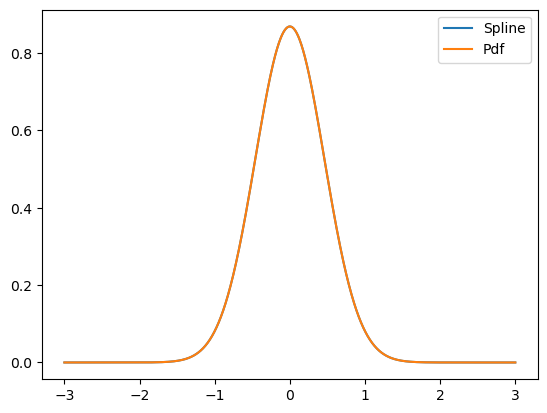

In [ ]:
fig, ax = plt.subplots()
ax.plot(grid_pdfs, CubicSpline(grid_pdfs, pdfs_discretized, axis=-1)(grid_pdfs)[0], label="Spline")
ax.plot(grid_pdfs, pdfs_discretized[0], label="Pdf")
plt.legend()
plt.show()

In [19]:
dens_to_look_at = 0
a = qd_from_dens(pdfs_discretized[dens_to_look_at], grid_pdfs, grid_qfs)
b = dens_from_qd(a, grid_qfs, grid_pdfs)
sigmas[:10]

array([0.45911424, 0.45864972, 0.90992458, 0.3375287 , 1.31826074,
       0.26744027, 4.07101118, 0.39391739, 3.16604967, 3.5862195 ])

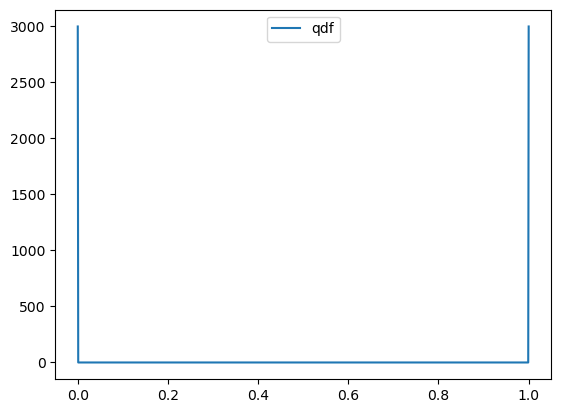

In [20]:
fig, ax = plt.subplots()
ax.plot(grid_qfs, a, label="qdf")
plt.legend()
plt.show()

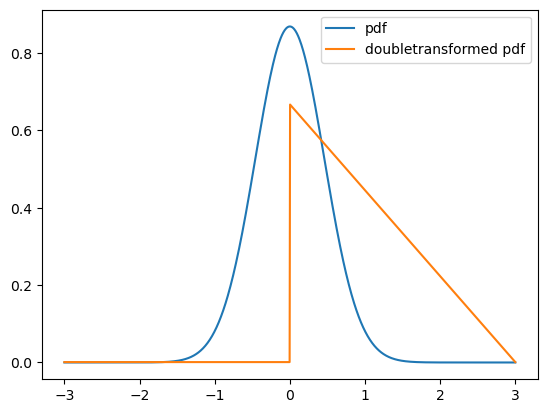

In [21]:
fig, ax = plt.subplots()
ax.plot(grid_pdfs, pdfs_discretized[dens_to_look_at], label="pdf")
ax.plot(grid_pdfs, b + 0.001, label="doubletransformed pdf")
plt.legend()
plt.show()

In [22]:
qdfs_discretized[0][499], pdfs_discretized[0][499]

(1.6035764993606226e-06, 0.8689204433808188)

In [23]:
(np.log(qdfs_discretized[0]) + np.log(np.interp(qfs_discretized[0], grid_pdfs, pdfs_discretized[0])))

array([-13.48379423, -13.48352711, -13.48377806, -13.48376727,
       -13.48354436, -13.48367151, -13.48378731, -13.4836369 ,
       -13.48369148, -13.48364458, -13.4836482 , -13.48374957,
       -13.48357528, -13.48368616, -13.48374455, -13.48369559,
       -13.48371943, -13.48377009, -13.48364643, -13.48361364,
       -13.48376753, -13.48362089, -13.48374895, -13.48362285,
       -13.48372133, -13.48368603, -13.48363173, -13.48367066,
       -13.48376383, -13.4837286 , -13.48367746, -13.48365499,
       -13.48364828, -13.48364868, -13.48365108, -13.48365315,
       -13.48365481, -13.4836577 , -13.48366477, -13.48367992,
       -13.48370769, -13.48375306, -13.48376896, -13.48371017,
       -13.48367585, -13.48367265, -13.4837068 , -13.48378405,
       -13.48371533, -13.48367739, -13.48369679, -13.48377821,
       -13.4837105 , -13.48368203, -13.48373028, -13.48374333,
       -13.48368629, -13.4837201 , -13.48375116, -13.48368948,
       -13.48373118, -13.4837343 , -13.48369318, -13.48

In [24]:
riemann_sum_arrays(grid_pdfs, pdfs_discretized[0])

1.0

In [25]:
def log_qd_transformation(qd, lqdsup, lqdsup):
    """Log quantile density transformation"""
    eps = 1e-4
    integral_qd = riemann_sum_arrays(qdsup, array=qd, axis=-1, cumsum=False)
    if not np.isclose(integral_qd[-1], np.ptp(dsup), atol=eps):
        msg = ("Quantile Density does not integrate to the range of the densities with "
        f"tolerance {eps}."
        f"\n Integral is: {integral_qd[...,-1]}"
        f"\n Range is: {np.ptp(dsup)}")
        raise ValueError(msg)
    return np.log(qd)


def inverse_transformation():

SyntaxError: incomplete input (1199505599.py, line 14)